In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

In [7]:
spark_session = SparkSession.builder.master("local[2]").appName("HousingRegression").getOrCreate()
spark_context = spark_session.sparkContext
spark_sql_context = SQLContext(spark_context)

/home/ndin/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
pd_train = pd.read_csv(TRAIN_INPUT)
pd_test = pd.read_csv(TEST_INPUT)
na_cols = pd_train.columns[pd_train.isna().any()].tolist()

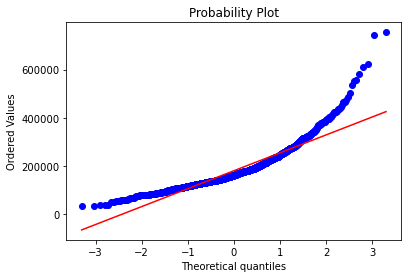

In [10]:
# Let's Explore how SalePrice is distributed against normal theoretical quantiles
fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_train['SalePrice'], plot=plt)

/home/ndin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

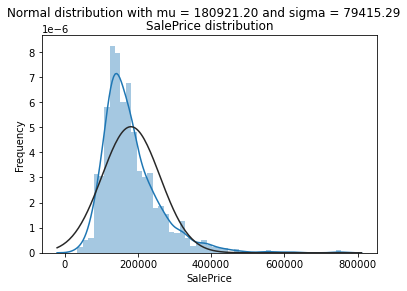

In [11]:
sns.distplot(pd_train['SalePrice'] , fit=norm);

# parameters
(mu, sigma) = norm.fit(pd_train['SalePrice'])

plt.suptitle('Normal distribution with mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [12]:
corr = pd_train.corr()

In [14]:
corr[['SalePrice']].sort_values(by='SalePrice',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


## Exploring Outliers

Text(0.5, 1.0, 'GarageCars vs SalePrice')

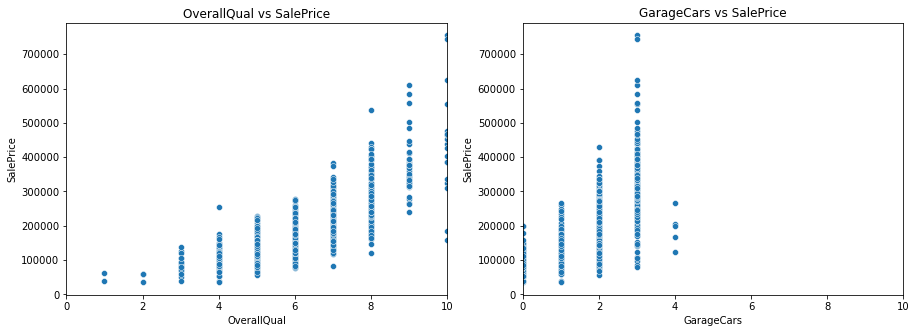

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,10)

sns.scatterplot(data=pd_train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')

Text(0.5, 1.0, '1stFlrSF vs SalePrice')

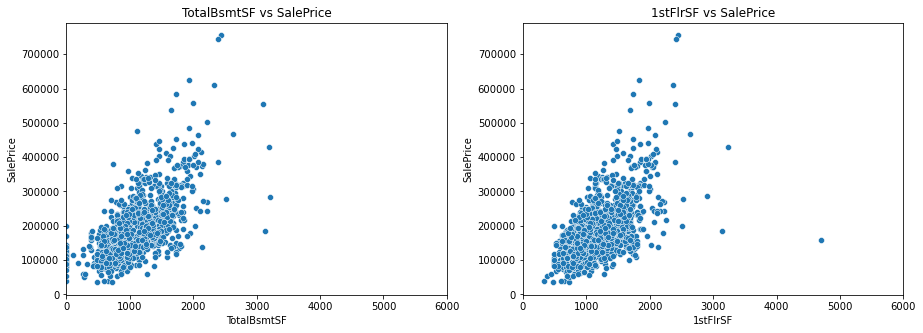

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')

## Handling Missing Data

In [17]:
total = pd_train.isnull().sum().sort_values(ascending=False)
percent = (pd_train.isnull().sum()/pd_train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(15)

,Total,Perc_missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [18]:
# We will remove features with missing proportion of more than 15% (thumb rule)

pd_train = pd_train.drop((missing[missing['Perc_missing'] >= 0.15]).index,1)
pd_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [20]:
pd_train['New'] = pd_train['OverallQual'] * pd_train['GarageArea'] * pd_train['GrLivArea']
pd_test['New'] = pd_test['OverallQual'] * pd_test['GarageArea'] * pd_test['GrLivArea']

# As some of the contestants have noticed, this results in a spike in model performance later

In [21]:
train_cols = list(pd_train.columns)
train_cols.remove('SalePrice')

In [22]:
#Make test ds feature set same as in train ds
pd_test = pd_test[train_cols]

In [23]:
pd_test.columns[pd_test.isna().any()].tolist()


['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType',
 'New']

In [24]:
# Althoug this is not the best solution to fill the NA-values with "None"/0, for most of the features 
# in the particular datas, it literally means "None"/0 (e.g. Garage Area, Garage Type, Condition) as the house
# probably doesn't have the garage.

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    pd_train[col] = pd_train[col].fillna(0)
    pd_test[col] = pd_test[col].fillna(0)
    
pd_train['MasVnrType'] = pd_train['MasVnrType'].fillna("None")
pd_test['MasVnrType'] = pd_test['MasVnrType'].fillna("None")

pd_train['MasVnrArea'] = pd_train['MasVnrArea'].fillna(0)
pd_test['MasVnrArea'] = pd_test['MasVnrArea'].fillna(0)

pd_train['Electrical'] = pd_train['Electrical'].fillna(pd_train['Electrical'].mode()[0])
pd_test['Electrical'] = pd_test['Electrical'].fillna(pd_test['Electrical'].mode()[0])

print(pd_train.isnull().sum().max()) # check if any missing values are left
print(pd_test.isnull().sum().max())

0
4


In [25]:
pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())
pd_test['BsmtUnfSF'] = pd_test['BsmtUnfSF'].fillna(pd_test['BsmtUnfSF'].mean())
pd_test['TotalBsmtSF'] = pd_test['TotalBsmtSF'].fillna(pd_test['TotalBsmtSF'].mean())
pd_test['BsmtFullBath'] = pd_test['BsmtFullBath'].fillna(pd_test['BsmtFullBath'].mean())
pd_test['BsmtHalfBath'] = pd_test['BsmtHalfBath'].fillna(pd_test['BsmtHalfBath'].mean())


In [26]:
cat_columns = pd_train.select_dtypes(include=['object']).columns
pd_train[cat_columns] = pd_train[cat_columns].fillna('NoData')
pd_test[cat_columns] = pd_test[cat_columns].fillna('NoData')

In [27]:
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>4500) 
                                & (pd_train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>5500) 
                                | (pd_train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[pd_train['GarageArea']>1100].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))

Dropping outliers resulted in 1460 instances in the new dataset
Dropping outliers resulted in 1458 instances in the new dataset
Dropping outliers resulted in 1449 instances in the new dataset
Dropping outliers resulted in 1444 instances in the new dataset


In [28]:
train_df = spark_session.createDataFrame(pd_train)
test_df = spark_session.createDataFrame(pd_test)

In [29]:
train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

In [48]:
from pyspark.sql.types import IntegerType

# As PySpark DFs can be finicky, sometimes your have to explicitly cast certain data types to columns

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

#train_df.printSchema()

In [31]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)

train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [33]:
print(len(train_indexed.columns))

90


In [34]:
test_string_columns = []

for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)

In [35]:
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]

pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

In [36]:
print(len(test_indexed.columns))

89


In [37]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))
        
num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [38]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

63
62


## Using Spark MLLib

In [39]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")

train_vector = vectorAssembler.transform(train_indexed)

In [40]:
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")

test_vector = vectorAssembler2.transform(test_indexed)

In [41]:
from pyspark.sql.functions import lit

test_vector = test_vector.withColumn("SalePrice", lit(0))

In [42]:
# Train-test split

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

In [43]:
# Simple baseline (linreg)

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='SalePrice', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1) # It is always a good idea to play with hyperparameters.
lr_model = lr.fit(train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(val)
lr_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE: 22095.419195
r2: 0.905872
+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|219774.32491472713|   223500|(62,[0,1,2,3,4,5,...|
|150747.78805771167|   149000|(62,[0,1,2,3,4,5,...|
|131725.44650416716|   139000|(62,[0,1,2,3,4,5,...|
|144362.07386323414|   139400|(62,[0,1,2,3,4,5,...|
|156761.68773676758|   154000|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.893594


In [44]:
# A more complex model with RF

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True
                          )
rf_model = rf.fit(train)

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 229676.6083333333|   223500|(62,[0,1,2,3,4,5,...|
|         144222.25|   149000|(62,[0,1,2,3,4,5,...|
|139410.62499999997|   139000|(62,[0,1,2,3,4,5,...|
|146130.85714285713|   139400|(62,[0,1,2,3,4,5,...|
|          136525.0|   154000|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.896092


## Marking Predictions and Submission

In [45]:
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

In [46]:
pred_pd = pred.toPandas()
save = pred_pd.to_csv("submission.csv", index=False)
save